In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np

import copy
import math

In [2]:
class Transformer(nn.Module):
    def __init__(self, encoder, decoder):
        super(Transformer, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        
    def encode(self, x):
        out = self.encoder(x)
        return out

    def decode(self, z, c):
        out = self.decoder(z, c)
        return out
    
    def forward(self, x, z):
        c = self.encode(x)
        y = self.decode(z, c)
        return y

In [4]:
class Encoder(nn.Module):
    # n_layer : Encoder Block 개수
    def __init__(self, encoder_block, n_layer):
        super(Encoder, self).__init__()
        self.layers = []
        for i in range(n_layer):
            self.layers.append(copy.deepcopy(encoder_block))
    
    def forward(self, x):
        # Encoder Block들을 순서대로 실행하면서 이전 block의 
        # output을 이후 block의 input으로 들어감.
        # 첫 block의 input은 Encoder 전체의 input인 x가 됨 
        out = x
        for layer in self.layers:
            out = layer(out)
        return out

- Encoder는 Encoder Block이 N개 쌓여진 형태. 논문에서는 N=6 을 사용함
    - Encoder Block은 input과 output의 형태가 동일함
    - 어떤 matrix가 input으로 들어가면 output은 input과 완전히 동일한 shape를 갖는 matrix가 됨
    - Encoder Block N개가 있는 Encoder를 볼 때, 첫번째 Encoder Block의 input은 문장의 embdding이 되고, output 이 다시 다음 Encoder 의 input으로 사용됨
        - 첫번째 block 에서 마지막 block의 output까지 동일한 shape을 유지함. context 형태

- Encoder 가 여러 개의 block을 겹쳐 쌓는 이유
    - 각 Encoder Block은 input으로 들어오는 vector에 대해 더 높은 차원(넓은 관점)에서의 context를 담는 것
    - 높은 차원의 context는 더 추상적인 정보라는 의미
    - Encoder Block을 겹겹이 쌓이다 보면 처음에는 원본 문장에 대한 낮은 수준의 context 지만 이후 context에 대한 context 와 같은 식으로 점차 높은 차원의 context가 저장되게 됨

In [5]:
class EncoderBlock(nn.Module):
    def __init__(self, self_attention, position_ff):
        super(EncoderBlock, self).__init__()
        self.self_attention = self_attention # multi-head attention layer
        self.position_ff = position_ff # position-wise feed-forward layer
        
    def forward(self, x):
        out = x
        out = self.self_attention(out)
        out = self.position_ff(out)
        return out

- Multi-Head Attention은 Scaled Dot-Proudct-Attention을 병렬적으로 여러 개 수행하는 layer
- query's attention (Q, K, V) = softmax(QK^t / root(dk))V
  - root(dk) : gradient vanishing 방지를 위해 값이 너무 커지지 않게 scaling 함
- Query, Key, Value vector의 dimension을 dk라고 함
- "it" 이 어느것을 지칭하는지 알아내야 할 경우
  - key와 value는 문장의 처움부터 끝까지 탐색함
  - n = 1 이라면..
    - query = (1 x dk) : "it"
    - key = (1 x dk) : "animal"
    - value = (1 x dk) : "animal"
      - q와 k를 내적(matmul) 함 : attention score를 구함 = (1 x 1)
  - n = 1이 아니고 1 : n Attention 이라면..
  - 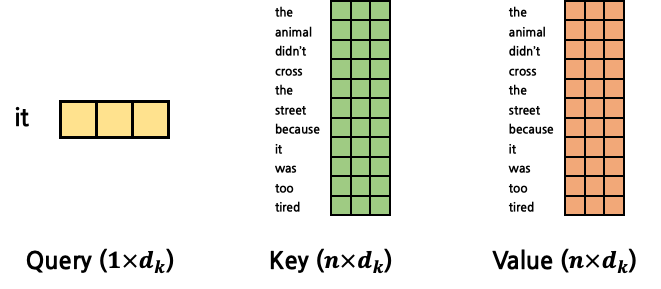
    - query = (1 x dk) : "it"
    - key = (n x dk) : "animal"
    - value = (n x dk) : "animal"
      - 1.attention score = query (1 x dk) matmul key.T (dk x n) = (1 x n)
      - 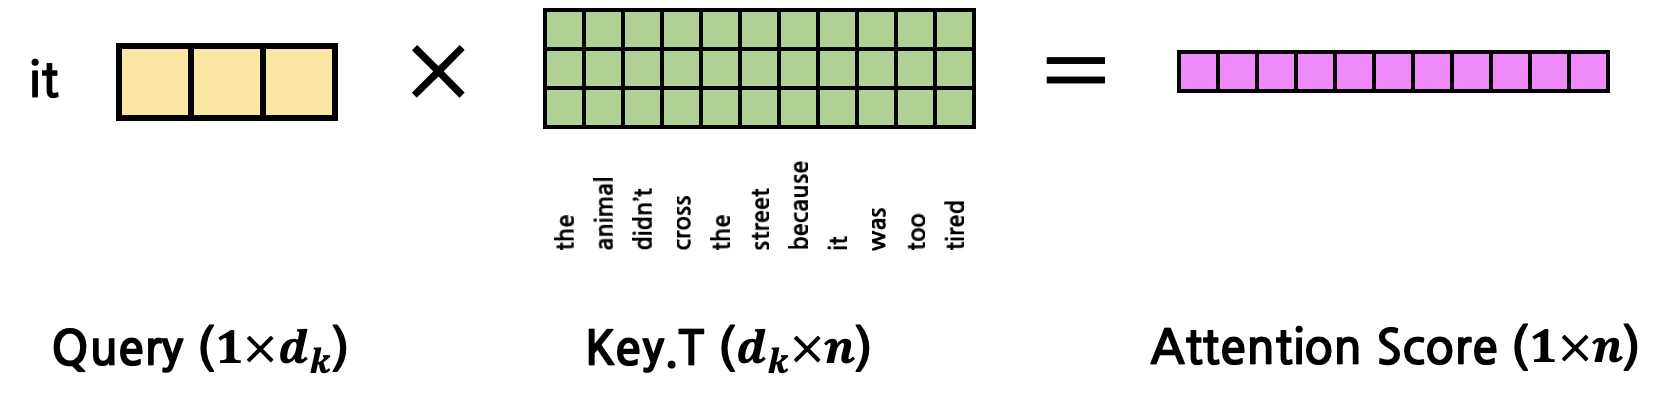
      - 2.softmax(1 x n) matmul value (n x dk) = (1 x dk)
      - 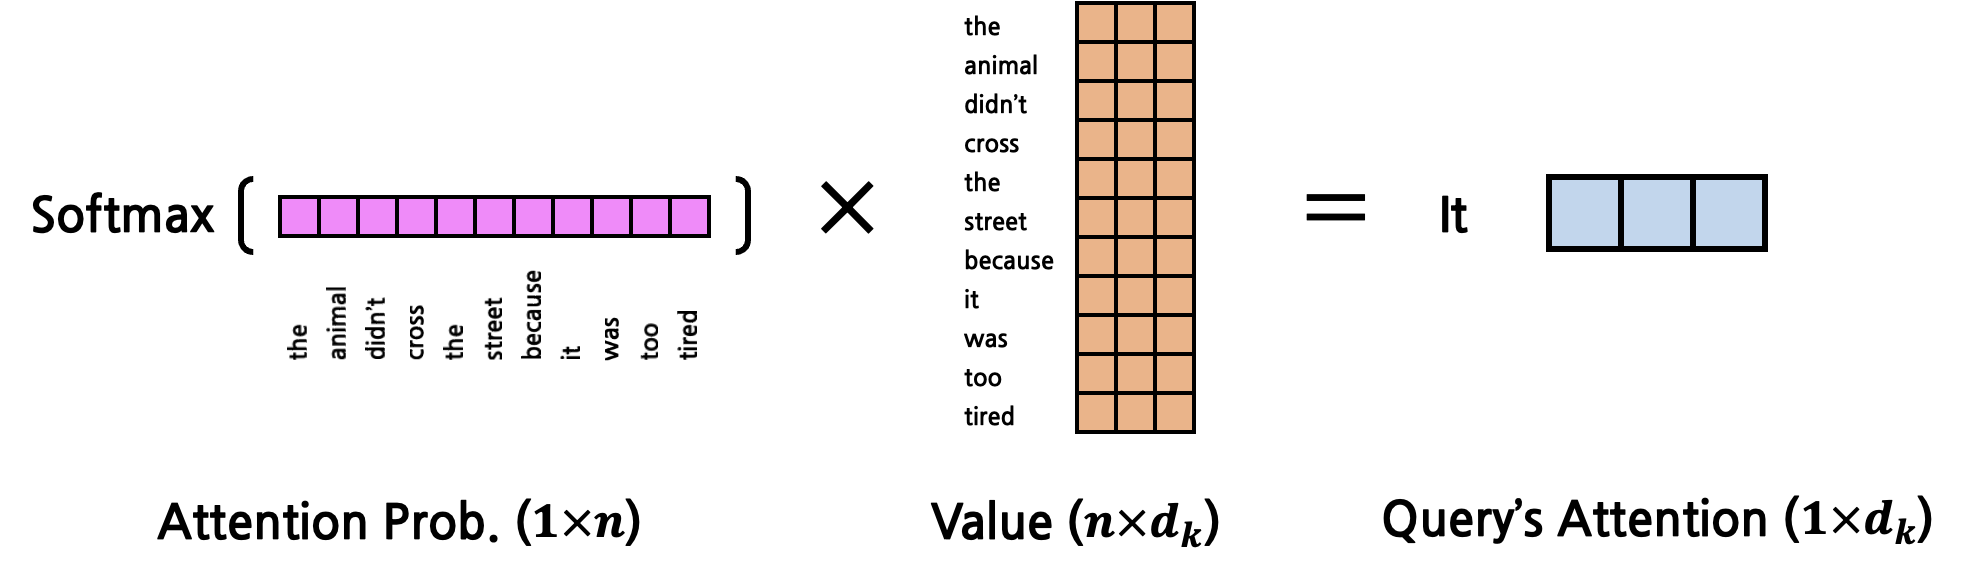

- 전체 문장에 대한 Attention Value 구할때는 다음과 같다  

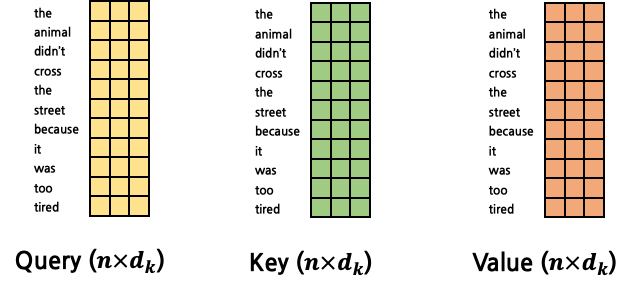  


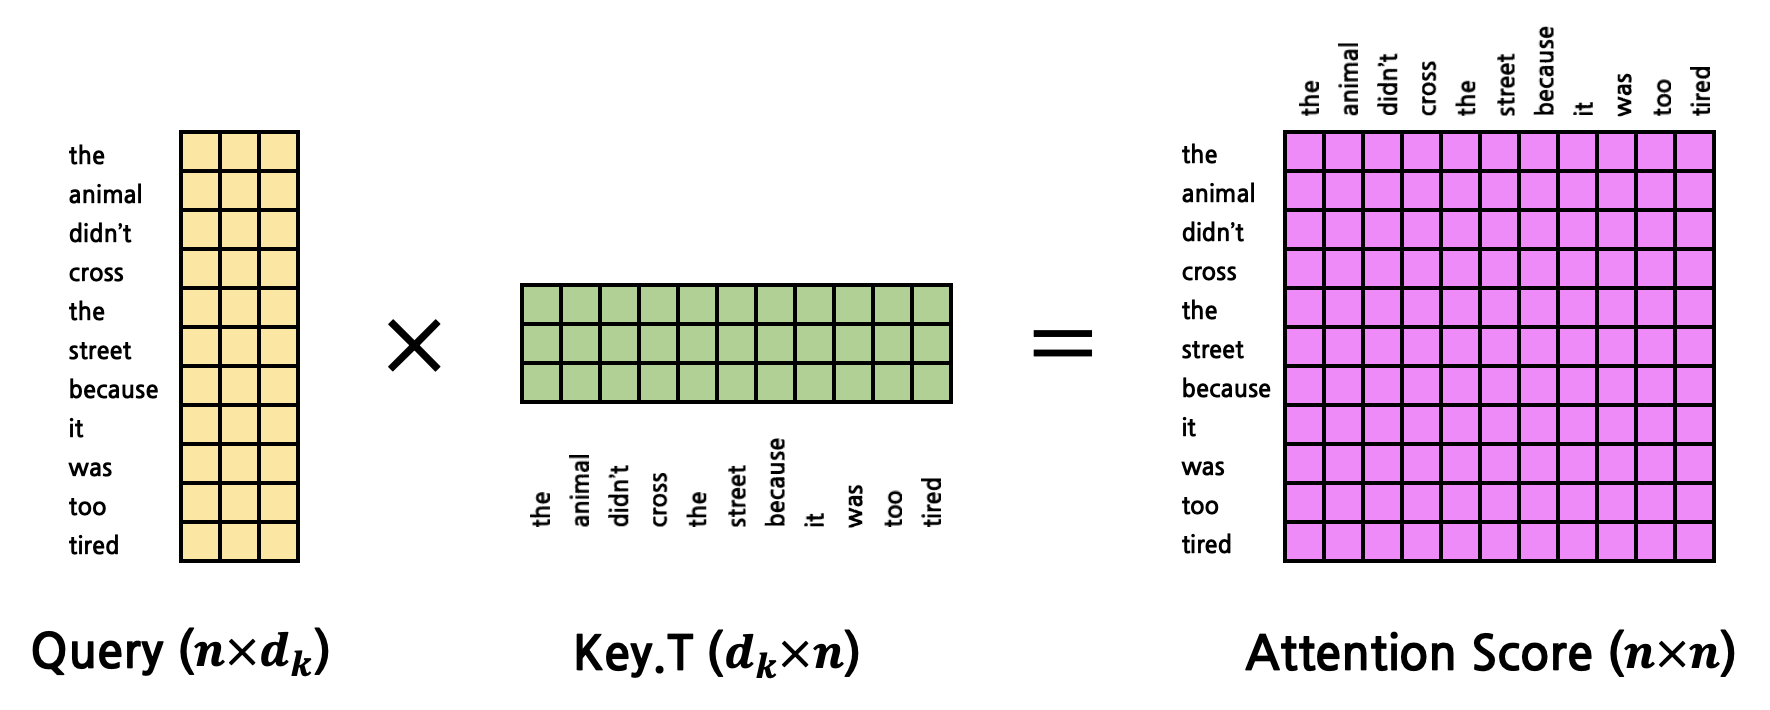  


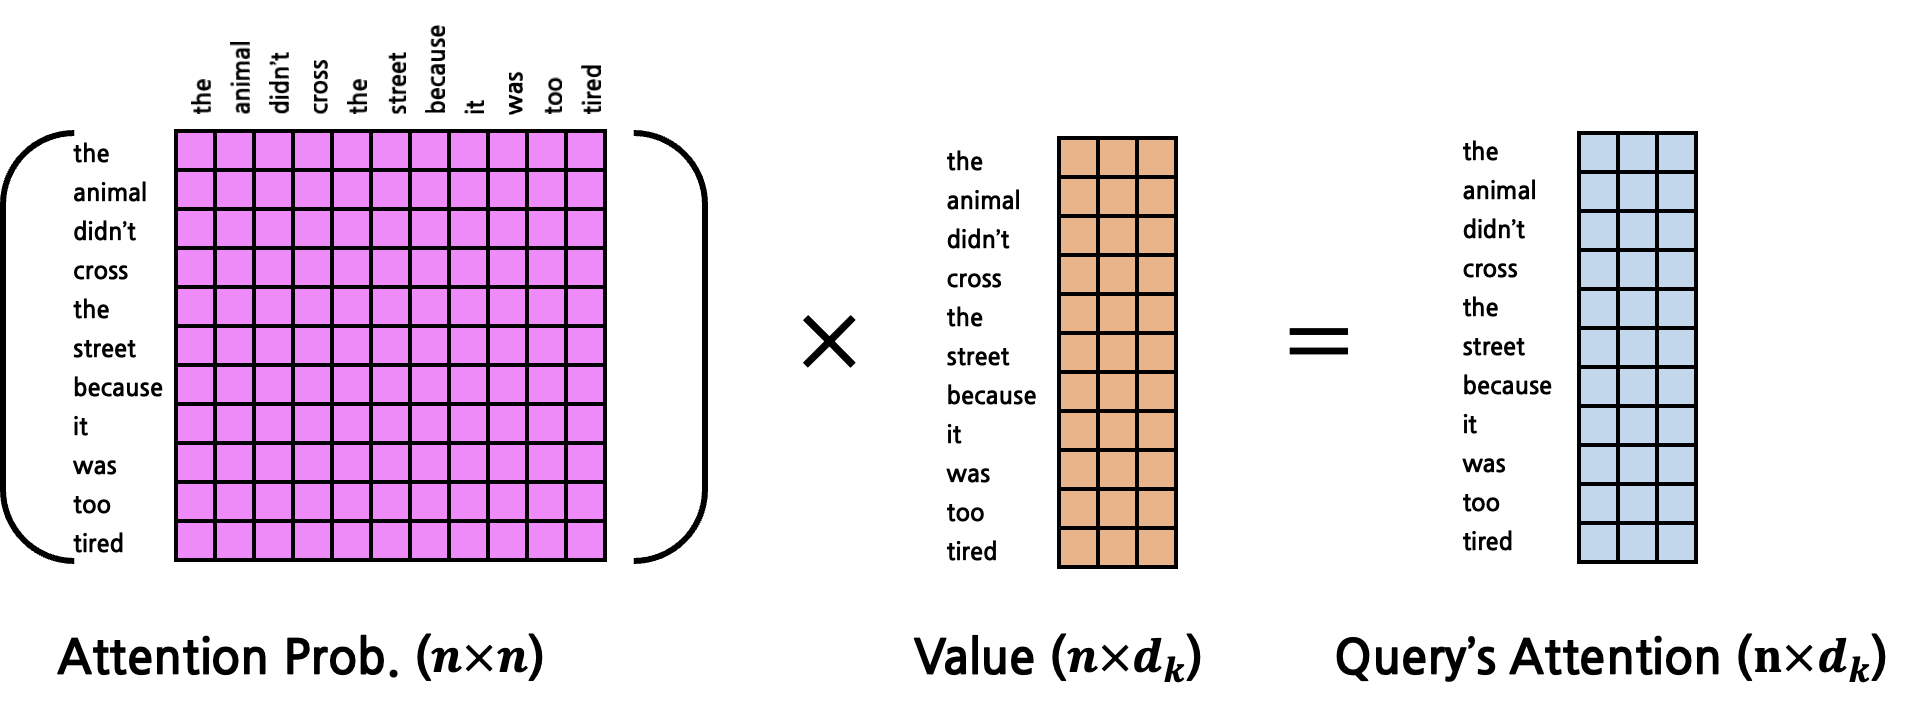  
  
- Q, K, V를 구하는 fc layer
  - input = word embedding vector. dim = d_embed. input shape = (n x d_embed)
  - output = Q, K, V = (n x dk)
  - 각각의 fc layer는 서로 다른 weight matrix(d_embed x dk)를 갖고 있기 때문에 output shape이 같더라도 Q, K, V의 실제값은 다름

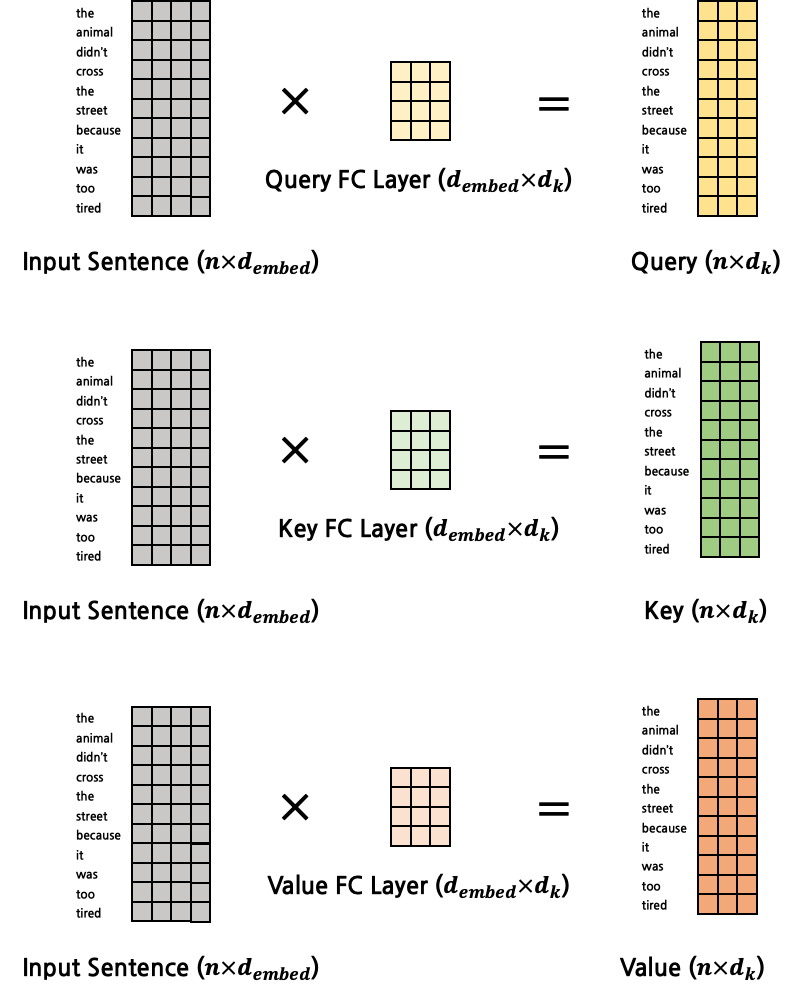  

- pad masking
- 문장을 word 단위로 tokenize한다면 token의 개수는 총 n개
- 만약의 각 token의 embedding dimension이 dembed 라고 한다면, 문장 전체의 embedding matrix는 n×dembed
  - 문장의 길이가 더 길거나 짧다면 그 때마다 input의 shape는 바뀌게 됨.
  - 실제 model 학습 과정에서는 한 문장 씩이 아닌 mini-batch씩 여러 문장이 와야 하는데 각 문장 마다의 length가 다를 경우 batch를 만들어낼 수 없음
  - 만약 seq_len이 20이라고 한다면 11개의 단어가 있으면 9개의 빈 token이 있게 됨. 이렇게 생겨난 비어있는 pad token에는 attention이 부여되어서는 안됨
  - 이러한 pad token들에 대해 attention이 부여되지 않도록 처리하는 것이 pad masking
  - masking은 (seq_len×seq_len) shape의 mask matrix에서 pad token에 해당하는 row, column의 모든 값은 0이고, 나머지는 모두 1

In [6]:
# encoder input -> ff layer -> output
# (n_batch, seq_len, d_embed) -> (n_batch, seq_len, dk) 로 변함

def calculate_attention(query, key, value, mask):
    # query, key, value: (n_batch, seq_len, dk=dim_key)
    # mask: (n_batch, seq_len, seq_len)
    d_k = key.shape(-1)
    attention_score = torch.matmul(query, key.transpose(-2, -1)) # Q x K^T, (n_batch, seq_len, seq_len)
    attention_score = attention_score / math.sqrt(d_k)
    if mask is not None:
        attention_score = attention_score.masked_fill(mask==0, -1e9)
    attention_prob = F.softmax(attention_score, dim=-1) # (n_batch, seq_len, seq_len)
    out = torch.matmul(attention_prob, value) # (n_batch, seq_len, d_k)
    return out


- Transformer는 Scaled Dot Attention을 한 Encoder Layer마다 1회씩 수행하는 것이 아니라 병렬적으로 h회 각각 수행한 뒤, 그 결과를 종합해 사용함
  - Multi-Head Attention Layer
  - 하나의 Attention만 반영한다고 했을 때 예시 문장에서 ‘it’의 Attention에는 ‘animal’의 것이 대부분을 차지하게 될 것임
  - 여러 종류의 attention을 반영한다고 했을 때 ‘tired’에 집중한 Attention까지 반영된다면, 최종적인 ‘it’의 Attention에는 모든 상태 정보가 담기게 됨

- Scaled Dot-Product Attention에서는 Q, K, V를 위해 FC layer가 총 3개 필요한데, 이를 h회 수행한다고 하면 3∗h개의 FC layer가 필요하게 됨
- 각각 연산의 최종 output은 (n x dk)인데, 총 h개의 (n x dk) matrix를 모두 concatenate해서 n x (dk ∗ h)의 shape를 갖는 matrix를 만들어냄
- (dk ∗ h) = dmodel 로 함. dmodel은 Encoder의 input shape인 dembed와 동일한 값을 사용함. d_embed == d_model 이라고 생각 해도 됨

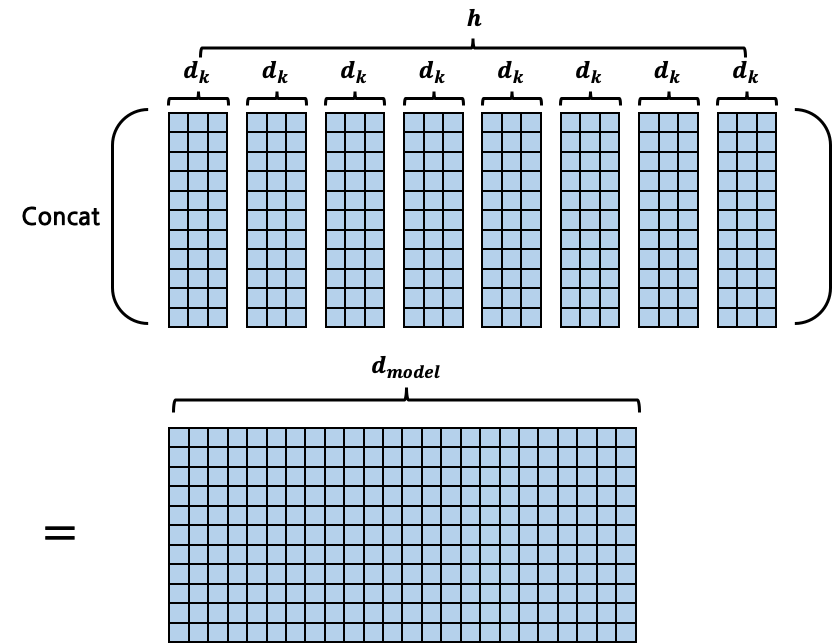

- 실제 연산은 병렬 처리를 위해 더 효율적인 방식으로 수행됨
  - Q, K, V 자체를 (n x dk) 가 아닌, (n x dmodel)로 생성해내서 한 번의 Self-Attention 계산으로 output을 만들게됨
  - Q, K, V를 생성해내기 위한 (dembed x dk)의 weight matrix를 갖는 FC layer를 3∗h개 운용할 필요 없이 (dembed X dmodel)의 weight matrix를 갖는 FC layer를 3개만 운용하면 됨
- 최종적으로 생성해된 matrix (n x dmodel)를 FC layer에 넣어 multi-head attention의 input과 같은 (n x dembed)의 matrix로 변환하는 과정이 필요함
- 마지막 FC layer의 input dimension은 dmodel, output dimension은 dembed가 됨.
  - (n x d_embed) -> multi-head attention 3 * (n X d_model) matmal (d_model x d_embed) -> (n x d_embed)

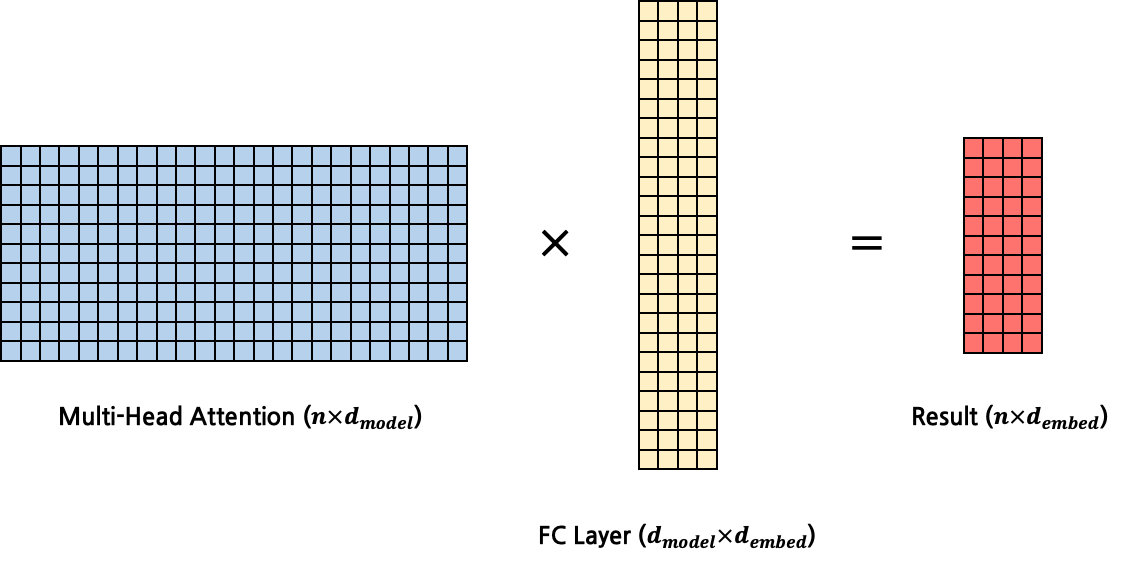  


In [7]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, d_model, h, qkv_fc, out_fc):
        super(MultiHeadAttentionLayer, self).__init__()
        self.d_model = d_model # dk * h (dim key) * encoder 개수
        self.h = h
        self.q_fc = copy.deepcopy(qkv_fc) # (d_embed, d_model)
        self.k_fc = copy.deepcopy(qkv_fc) # (d_embed, d_model)
        self.v_fc = copy.deepcopy(qkv_fc) # (d_embed, d_model)
        self.out_fc = out_fc              # (d_model, d_embed)
    
    def calculate_attention(self, query, key, value, mask):
        # dk를 중심으로 Q와 K 사이 행렬곱 연산을 수행하기 때문에 
        # Q, K, V의 마지막 dimension은 반드시 dk여야만 함

        # query, key, value: (n_batch, h, seq_len, d_k)
        # mask: (n_batch, 1, seq_len, seq_len)
        d_k = key.shape[-1]
        
        # attention_score의 shape는 마지막 두 dimension이 반드시
        # (seq_len×seq_len) 이어야만 masking이 적용될 수 있기 때문에 
        # Q, K, V의 마지막 직전 dimension(shape[-2])는 반드시 seq_len이어야만 함        
        attention_score = torch.matmul(query, key.transpose(-2, -1)) # Q x K^T, (n_batch, h, seq_len, seq_len)
        attention_score = attention_score / math.sqrt(d_k)
        if mask is not None:
            attention_score = attention_score.masked_fill(mask==0, -1e9)
        attention_prob = F.softmax(attention_score, dim=-1) # (n_batch, h, seq_len, seq_len)
        out = torch.matmul(attention_prob, value) # (n_batch, h, seq_len, d_k)
        return out

        
    def forward(self, *args, query, key, value, mask=None):
        # input sentence embedding 값
        # query, key, value: (n_batch, seq_len, d_embed)        
        
        # mask: (n_batch, seq_len, seq_len)
        # return value: (n_batch, h, seq_len, d_k)
        n_batch = query.size(0)
        
        def transform(x, fc): # (n_batch, seq_len, d_embed)
            out = fc(x) # (n_batch, seq_len, d_model)
            out = out.view(n_batch, -1, self.h, self.d_model // self.h) # (n_batch, seq_len, h, d_k)
            out = out.transpose(1, 2) # (n_batch, h, seq_len, d_k)
            return out # (n_batch, seq_len, d_model)
        
        # calculate_attention 에서 input shape 형태가 
        # (n_batch x ... x seq_len x d_k) 이므로 d_model을 h와 d_k로 분리하고
        # 각각을 하나의 dim으로 분리
        query = transform(query, self.q_fc) # (n_batch, h, seq_len, d_k)
        key = transform(key, self.k_fc) # (n_batch, h, seq_len, d_k)
        value = transform(value, self.v_fc) # (n_batch, h, seq_len, d_k)
        
        out = self.calculate_attention(query, key, value, mask) # (n_batch, h, seq_len, d_k)
        
        # Multi-Head Attention Layer 역시 shape에 대해 동일해야 하기 때문에
        # output shape는 input과 같은 (n_batch×seq_len×dembed)여야 함.
        # 이를 위해 h와 seq_len의 순서를 뒤바꾸고(transpose(1, 2)) 
        # 다시 h와 dk를 dmodel로 결합함        
        out = out.transpose(1, 2) # (n_batch, seq_len, h, d_k)
        out = out.contiguous().view(n_batch, -1, self.d_model) # (n_batch, seq_len, d_model)

        # FC Layer를 거쳐 dmodel을 dembed로 변환함
        out = self.out_fc(out) # (n_batch, seq_len, d_embed)

        return out

In [8]:
class EncoderBlock(nn.Module):
    def __init__(self, self_attention, position_ff):
        super(EncoderBlock, self).__init__()
        self.self_attention = self_attention
        self.position_ff = position_ff
    
    def forward(self, src, src_mask):
        # pad mask는 Encoder 외부에서 생성하이므로 Encoder Block의 
        # forward()에서 인자로 받음
        out = src
        # query, key, value를 인자로 받아야 하므로 forward의 인자는 x, x, x, mask 형태임
        out = self.self_attention(query=out, key=out, value=out, mask=src_mask)
        out = self.position_ff(out)
        return out

In [10]:
class Encoder(nn.Module):
    def __init__(self, encoder_layer, n_layer):
        super(Encoder, self).__init__()
        self.layers = []
        for i in range(n_layer):
            self.layers.append(copy.deepcopy(encoder_layer))
    
    def forward(self, src, src_mask): # mask 인자 추자
        out = src
        for layer in self.layers:
            out = layer(out, src_mask)
        return out

In [9]:
class Transformer(nn.Module):
    def __init__(self, encoder, decoder):
        super(Transformer, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        
    def encode(self, src, src_mask): # mask 인자 추자
        out = self.encoder(src, src_mask)
        return out

    def decode(self, z, c):
        out = self.decoder(z, c)
        return out
    
    def forward(self, src, tgt, src_mask): # mask 인자 추자
        encoder_out = self.encode(src, src_mask)
        y = self.decode(tgt, encoder_out)
        return y

- Position-wise Feed Forward Layer
  - 2개의 FC Layer를 갖는 Layer
  - 각 FC Layer는 (dembed x d_ff), (d_ff x dembed)의 weight matrix
  - 다음 Encoder Block에게 shape를 유지한 채 넘겨줘야 하므로 shape이 동일해야함
- Feed Forward Layer는 Multi-Head Attention Layer의 output을 input으로 받아 연산을 수행하고, 다음 Encoder Block에게 output을 넘겨줌
  - 논문에서는 첫번째 FC Layer의 output에 ReLU()를 적용함
$$\text{FFN}(x)=\text{max}(0, xW_1+b_1)W_2 + b_2$$

In [4]:
class PositionWiseFeedForwardLayer(nn.Module):
    def __init__(self, fc1, fc2):
        super(PositionWiseFeedForwardLayer, self).__init__()
        self.fc1 = fc1 # (d_embed, d_ff)
        self.fc2 = fc2 # (d_ff, d_embed)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        out = x
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        return out

In [5]:
class ResidualConnectionLayer(nn.Module):
    def __init__(self):
        super(ResidualConnectionLayer, self).__init__()

    def forward(self, x, sub_layer):
        out = x
        out = sub_layer(out)
        out = out + x
        return out

In [6]:
class EncoderBlock(nn.Module):
    def __init__(self, self_attention, position_ff):
        super(EncoderBlock, self).__init__()
        self.self_attention = self_attention
        self.position_ff = position_ff
        self.residuals = [ResidualConnectionLayer() for _ in range(2)]

    def forward(self, src, src_mask):
        out = src
        # residual layer 의 forward는 sub layer로 전달할때 필요에 따라
        # lambda 식으로 전달할 수 있음 
        out = self.residuals[0](
            out,
            lambda out: self.self_attention(
                query=out, key=out, value=out, mask=src_mask))
        out = self.residuals[1](out, self.position_ff)
        return out

In [10]:
class Transformer(nn.Module):
    def __init__(self, encoder, decoder):
        super(Transformer, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def encode(self, src, src_mask):
        out = self.encoder(src, src_mask)
        return out

    def decode(self, tgt, encoder_out, tgt_mask):
        out = self.decode(tgt, encoder_out, tgt_mask)
        return out

    def forward(self, src, tgt):
        src_mask = self.make_src_mask(src)
        tgt_mask = self.make_tgt_mask(tgt)
        encoder_out = self.encode(src, src_mask)
        y = self.decode(tgt, encoder_out, tgt_mask)
        return y
    
    # self-attention 에서는 query와 key가 동일함
    # cross-attention 에서는 query가 source(decoder), key가 target(encoder) 값
    def make_pad_mask(self, query, key, pad_idx=1):
        # input : embedding layer 통과하기 전 token sequence 상태
        # query: (n_batch, query_seq_len)
        # key: (n_batch, key_seq_len)
        # pad_idx: <pad>의 index와 일치하는 token은 0, 그 외는 1인 mask 생성
        query_seq_len, key_seq_len = query.size(1), key.size(1)
        
        key_mask = key.ne(pad_idx).unsqueeze(1).unsqueeze(2) # (n_batch, 1, 1, key_seq_len)
        key_mask = key_mask.repeat(1, 1, query_seq_len, 1) # (n_bathc, 1, query_seq_len, key_seq_len)
        
        query_mask = query.ne(pad_idx).unsqueeze(1).unsqueeze(3) # (n_batch, 1, query_seq_len, 1)
        query_mask = query_mask.repeat(1, 1, 1, key_seq_len) # (n_batch, 1, query_seq_len, key_seq_len)
        
        mask = key_mask & query_mask
        mask.requires_grad = False
        return mask

    def make_src_mask(self, src):
        # Transformer method 로 추가됨
        pad_mask = self.make_pad_mask(src, src)
        return pad_mask

    # 병렬 연산을 위해 ground truth의 embedding을 input으로 그대로 사용하게 되면
    # Decoder에서 Self-Attention 연산을 수행하게 될 때 현재 출력해야 하는 token의 
    # 정답까지 알고 있는 상황이 발생하므로 masking을 적용해야 함
    # i번째 token을 생성할 때 1 ~ i−1의 token은 보이지 않도록 처리함
    def make_subsequent_mask(query, key):
        # query: (n_batch, query_seq_len)
        # key: (n_batch, key_seq_len)
        query_seq_len, key_seq_len = query.size(1), key.size(1)

        # np.tril을 이용해 lower triangle을 생성함
        tril = np.tril(np.ones((query_seq_len, key_seq_len)), k=0).astype('uint8')
        mask = torch.tensor(tril, dtype=torch.bool, requires_grad=False, device=query.device)
        return mask

    def make_tgt_mask(self, tgt):
        pad_mask = self.make_pad_mask(tgt, tgt)
        seq_mask = self.make_subsequent_mask(tgt, tgt)
        mask = pad_mask & seq_mask
        return pad_mask & seq_mask

decoder block  

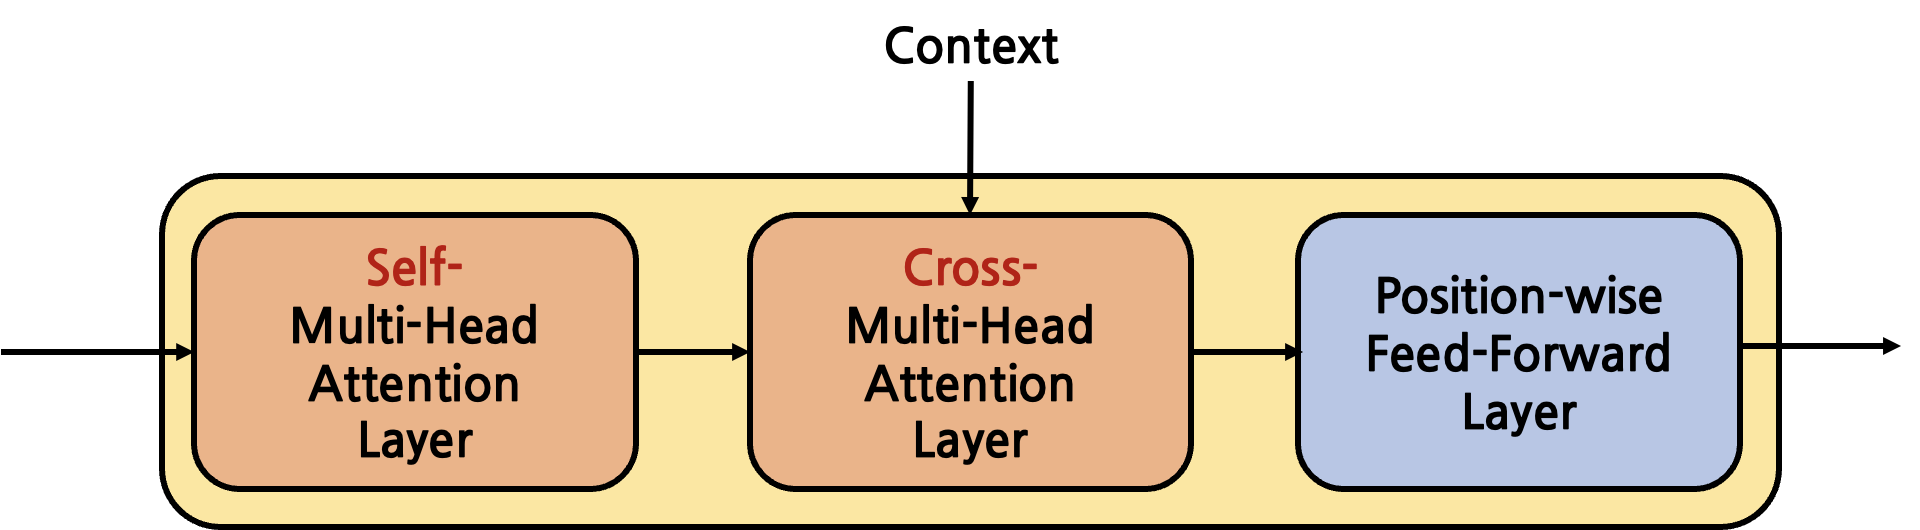  

- Decoder Block은 Multi-Head Attention Layer가 2개 있음
- 첫번째 Self-Multi-Head Attention Layer는 Decoder의 input으로 주어지는 sentence 내부에서의 Attention을 계산함
  - 이 때 일반적인 pad masking뿐만 아니라 subsequent masking이 적용되기 떄문에 Masked-Multi-Head Attention Layer라고도 함
- 두번째는 Encoder에서 넘어온 context를 Key, Value로 사용한다는 점에서 Cross-Multi-Head Attention Layer라고 부름
  - Encoder의 context는 Decoder 내 각 Decoder Block의 Cross-Multi-Head Attention Layer에서 사용됨
- 마지막 Position-wise Feed-Forward Layer는 Encoder Block의 것과 동일함

- Self-Multi-Head Attention Layer
- Encoder와 동일한 구조이며 mask로 들어오는 인자가 일반적인 pad masking에 더해 subsequent masking이 더해져 있음
- Ground Truth sentence에 내부에서의 Attention을 계산함

- Cross-Multi-Head Attention Layer
- Decoder Block 내 이전 Self-Multi-Head Attention Layer에서 넘어온 output을 input으로 받음
  - 추가적으로 Encoder에서 도출된 context도 input으로 받음
  - Decoder Block 내부에서 전달된 input(Self-Multi-Head Attention Layer의 output)은 Query로써 사용
  - Encoder에서 넘어온 context는 Key와 Value로써 사용하게 됨
- Decoder에서 도출하고자 하는 최종 output은 teacher forcing으로 넘어온 sentence와 최대한 유사한 predicted sentence 임
- Decoder Block 내 이전 layer에서 넘어오는 input이 Query가 되고, 이에 상응하는 Encoder에서의 Attention을 찾기 위해 context를 Key, Value로 두게 됨

In [ ]:
class Decoder(nn.Module):
    def __init__(self, decoder_block, n_layer):
        super(Decoder, self).__init__()
        self.n_layer = n_layer
        self.layers = nn.ModuleList(
            [copy.deepcopy(decoder_block) for _ in range(self.n_layer)])

    def forward(self, tgt, encoder_out, tgt_mask, src_tgt_mask):
        # encoder_out: encoder에서의 최종 output
        # tgt_mask: Decoder의 input인 target sentence의 pad masking과 subsequent masking
        # make_tgt_mask()의 결과 값 mask.
        # src_tgt_mask: Encoder에서 넘어온 key, value 사이의 pad masking.
        # 이를 구하는 make_src_tgt_mask()를 작성한다. 이 때를 위해 make_pad_mask()를 query와 key를 분리해서 인자로 받도록 한 것이다.
        out = tgt
        for layer in self.layers:
            out = layer(out, encoder_out, tgt_mask, src_tgt_mask)
        return out

In [ ]:
class DecoderBlock(nn.Module):
    def __init__(self, self_attention, cross_attention, position_ff):
        super(DecoderBlock, self).__init__()
        self.self_attention = self_attention
        self.cross_attention = cross_attention
        self.position_ff = position_ff
        self.residuals = [ResidualConnectionLayer() for _ in range(3)]

    def forward(self, tgt, encoder_out, tgt_mask, src_tgt_mask):
        out = tgt
        out = self.residuals[0](
            out, 
            lambda out: self.self_attention(
                query=out, key=out, value=out, mask=tgt_mask))
        out = self.residuals[1](
            out, 
            lambda out: self.cross_attention(
                query=out, key=encoder_out, value=encoder_out, mask=src_tgt_mask))
        out = self.residuals[2](out, self.position_ff)
        return out

In [ ]:
class Transformer(nn.Module):

    def decode(self, tgt, encoder_out, tgt_mask, src_tgt_mask):
        out = self.decode(tgt, encoder_out, tgt_mask, src_tgt_mask)
        return out

    def make_src_tgt_mask(self, src, tgt):
        pad_mask = self.make_pad_mask(tgt, src)
        return pad_mask

    def forward(self, src, tgt):
        src_mask = self.make_src_mask(src)
        tgt_mask = self.make_tgt_mask(tgt)
        src_tgt_mask = self.make_src_tgt_mask(src, tgt)
        encoder_out = self.encode(src, src_mask)
        y = self.decode(tgt, encoder_out, tgt_mask, src_tgt_mask)
        return y

- Transformer Input (Positional Encoding)
- Transformer의 input으로 들어오는 문장의 shape는 (n_batch x seq_len)인데 Encoder와 Decoder의 input은 (n_batch x seq_len x d_embed)의 shape를 가진 것으로 가정함. 
  - Embedding 과정을 생략했기 때문
  - Transformer는 source/target sentence에 대한 각각의 Embedding이 포함됨
  - Embedding은 Token Embedding과 Positional Encoding의 sequential로 구성됨
- Token Embedding은 vocabulary와 d_embed를 사용해 embedding을 생성함
- embedding에도 scaling을 적용함 forward()에서 √(d_embed)를 곱하게 됨

In [ ]:
class TransformerEmbedding(nn.Module):
    def __init__(self, token_embed, pos_embed):
        super(TransformerEmbedding, self).__init__()
        self.embedding = nn.Sequential(token_embed, pos_embed)

    def forward(self, x):
        out = self.embedding(x)
        return out

class TokenEmbedding(nn.Module):
    def __init__(self, d_embed, vocab_size):
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, d_embed)
        self.d_embed = d_embed

    def forward(self, x):
        out = self.embedding(x) * math.sqrt(self.d_embed)
        return out

- PositionalEncoding의 목적은 positional 정보(token, index, number 등)를 정규화시키기 위한 것
- index number를 positionalEncoding으로 사용하게 될 경우
  - training data에서는 최대 문장의 길이가 30이었는데 test data에서 길이 50인 문장이 나오게 된다면 30~49의 index는 model이 학습한 적이 없는 정보가 됨
  - 이는 제대로 된 성능을 기대하기 어려우므로 positonal 정보를 일정한 범위 안의 실수로 제약해두는 것
  - 여기서 sin함수와 cos함수를 사용하는데 짝수 index에는 sin함수를 홀수 index에는 cos 함수를 사용하게 됨
  - 이를 사용할 경우 항상 -1에서 1 사이의 값만이 positional 정보로 사용되게 됨
- 구현 상 생성자에서 만든 encoding을 forward() 내부에서 slicing해 사용하게 되는데 PositionalEncoding은 학습되는 parameter가 아니기 때문에 requires_grad=False 를 적용 해야 함

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_embed, max_len=256, device=torch.device("cpu")):
        super(PositionalEncoding, self).__init__()
        encoding = torch.zeros(max_len, d_embed)
        encoding.requires_grad = False
        position = torch.arange(0, max_len).float().unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_embed, 2) * -(math.log(10000.0) / d_embed))
        encoding[:, 0::2] = torch.sin(position * div_term)
        encoding[:, 1::2] = torch.cos(position * div_term)
        self.encoding = encoding.unsqueeze(0).to(device)

    def forward(self, x):
        _, seq_len, _ = x.size()
        pos_embed = self.encoding[:, :seq_len, :]
        out = x + pos_embed
        return out

- After Decoder (Generator)
  - Decoder의 output이 Transformer의 최종 output이 아님
  - Decoder의 output shape 는 (n_batch x seq_len x dembed)인데 원하는 output은 target sentence인 (n_batch x seq_len)임
  - Embedding이 아닌 실제 target vocab에서의 token sequence를 원하는 것. 이를 위해 추가적인 FC layer를 거쳐감
    - 이 layer를 Generator라고 함
- Generator가 하는 일은 Decoder output의 마지막 dimension을 dembed에서 len(vocab)으로 변경하는 것
- token에 대응시킬 수 있는 shape가 되어 softmax()를 사용해 각 문장에 대한 확률값으로 변환 하게 되는데, 이 때 log_softmax()를 사용해 성능을 향상시킴

In [ ]:
class Transformer(nn.Module):
    def __init__(self, src_embed, tgt_embed, encoder, decoder, generator):
        super(Transformer, self).__init__()
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.encoder = encoder
        self.decoder = decoder
        self.generator = generator
    # ...
    def forward(self, src, tgt):
        src_mask = self.make_src_mask(src)
        tgt_mask = self.make_tgt_mask(tgt)
        src_tgt_mask = self.make_src_tgt_mask(src, tgt)
        encoder_out = self.encode(src, src_mask)
        decoder_out = self.decode(tgt, encoder_out, tgt_mask, src_tgt_mask)
        out = self.generator(decoder_out)
        # log_softmax()에서는 dim=-1이 되는데, 마지막 dimension인 len(vocab)에 대한 확률값을 구해야 하기 때문
        out = F.log_softmax(out, dim=-1)
        return out, decoder_out